# Tarea Semanal 6: Estimación espectral. Ventanas en acción!
## Magdalena Noé
En esta tarea continuaremos con el capítulo 14 de Holton. DSP Principles and App.

Se trabajara sobre una señal con amplitud y frecuencia variable y se estimara su amplitud y frecuencia intrinseca con 4 tipos de ventanas:
- Rectangular (sin ventana)
- Flattop
- Blackmanharris
- Coseno
### Librerías

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from scipy.signal import windows
from matplotlib.ticker import FuncFormatter # Para modificar los ejes en gráficos de zero-padding
import pandas as pd # Para las tablas

import warnings 
warnings.filterwarnings("ignore") # Para ignorar una warning de matplotlib que le molesta como armo los historiogramas superpuestos
#warnings.filterwarnings("ignore", category='matplotlib.MatplotlibDeprecationWarning')

Parametros de la señal
Las variables aleateorias fr y na, correspondientes a la variacion de frecuencia y amplitud correspondientemente, se ven definidas por las siguientes distribuciones de probabilidad:

$$ fr∼U(−2,2);na∼N(0,σ^{2}) $$

In [134]:
fs = 1000       # Frecuencia de muestreo [Hz]
N = fs          # cantidad de muestras

a0 = 2                              #Amplitud señal
sigma = np.sqrt(1/10)               # SNR de 10dB
na = np.random.normal(0, sigma)     #Incertidumbre de amplitud

omega0 = np.pi/2                        #Frecuencia señal [Hz]
fr = np.random.uniform(-2, 2)           #Incertidumbre de frecuencia
omega1 = omega0 + fr*(2*np.pi)    #Frecuencia con incertidumbre


Generacion de señal

In [135]:
k = np.arange(N)                # Array de enteros de 0 a N-1
x = a0 * np.sin(omega1*k) + na  # Señal

Declaracion de las ventanas W

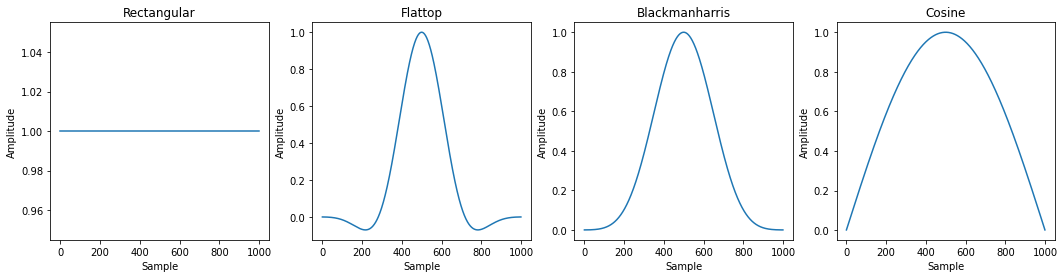

In [136]:
Wrectangular = windows.boxcar(N)                # Arr de 1 constantes, sin ventana
Wflattop = windows.flattop(N)                   # Ventana flattop (sombrero de bruja)
Wblackmanharris = windows.blackmanharris(N)     # Ventana blackmanharris (campana)
Wcosine = windows.cosine(N)                     # Ventana cosine (medio coseno, loma)
arr_W = [Wrectangular, Wflattop, Wblackmanharris, Wcosine]
arr_titulos_W = ["Rectangular", "flattop", "blackmanharris", "cosine"]

# GRAFICOS
plt.figure(figsize=(18, 4))
plt.subplot(1,4,1); plt.plot(Wrectangular); plt.title("Rectangular"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,2); plt.plot(Wflattop); plt.title("Flattop"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,3); plt.plot(Wblackmanharris); plt.title("Blackmanharris"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,4); plt.plot(Wcosine); plt.title("Cosine"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.show()

### Estimamos la amplitud $a_0$ y la frecuencia $ \omega_0 $. 
En ambos analisis se realiz un ventaneo de la señal $X$, por lo que recorreremos los 4 casos de ventanas declaradas anteriormente.

Para estimar la amplitud se realiza la fft de la señal ventaneada y lee el indice correspondiente a $\omega_0 = \pi/2$. A dicha estimacion la llamaremos $a_1$

$$ a^i1=|X^i_w(Ω0)|=|F{x(n)⋅w_i(n)}| $$

Para estimar la frecuencia se detecta el maximo valor de espectro (fft) y retorna la frecuencia en radianes. A dicha estimacion la llamaremos $Ω_1$

$$ Ω^i1=arg max{|Xiw(Ω)|} $$


In [137]:
def estimar_amplitud(Xw):
    omega0_ind = int(N // 4) # indice de omega0 = pi/2 -> Siendo T = 2pi y la señal un seno, el maximo estara en pi/2 -> indice = N/4
    return Xw[omega0_ind] # Retorno el valor modulo en pi/2 (pico de señal seno)

def estimar_frecuencia(Xw):
    Xw = Xw[len(Xw)//2:]  # Solo tomo una mitad del array, no me interesa el espejo de espectro negativo
    f_ind = np.argmax(Xw) # Retorna argumento con el maximo pico, que corresponde a la frecuencia fundamental
    #omega = 2 * np.pi * f_ind / N # Paso frecuencia a radianes/s
    return f_ind # Retorno frecuencia en hz

def estimar_amp_frec(x,w):
    xw = x * w
    fft_xw = np.array(np.abs(fft(xw)))
    amplitud = estimar_amplitud(fft_xw)
    frecuencia = estimar_frecuencia(fft_xw)
    return amplitud, frecuencia, fft_xw

## Experimentación

Una vez ya declarada la señal, las ventanas a aplicarle y las funciones para obtener una estimacion de amplitud y frecuencia, vamos a correr esta estimacion 200 veces (cant_realizaciones) con 1000 muestras por experimento (N).

La SNR se parametrizara para 3dB, con una alta presencia de ruido, y 10 dB, es decir, con un ruido mas atenuado.
Para los 8 casos (4 ventanas y 2 tipos de SNR) se analizara:
- Sesgo amplitud: diferencia promedio entre valor estimado y el real ($a_0 = 2$)
- Varianza amplitud: cuánto varían las estimaciones de amplitud entre realizaciones
- Sesgo frecuencia: diferencia promedio entre frecuencia estimada y real ($ω0 = π/2$)
- Varianza frecuencia: cuánto se dispersan las estimaciones de frecuencia

In [138]:
cant_realizaciones = 200
SNR_dB = [3, 10]
SNR_lin = [10**(SNR_dB[0]/10), 10**(SNR_dB[1]/10)]

In [139]:
P_signal = 1
P_noise = P_signal / SNR_lin[0]                         # SNR_lin[0] = 10**(3/10)
sigma = np.sqrt(P_noise)                                # sigma del ruido blanco gaussiano para 1/3dB
na_3dB = np.random.normal(0, sigma, size=(cant_realizaciones,N)) # 200 incertidumbres de amplitud para las 200 realizaciones

P_noise = P_signal / SNR_lin[1]                         # SNR_lin[1] = 10**(10/10)
sigma = np.sqrt(P_noise)                                # sigma del ruido blanco gaussiano para 1/10dB
na_10dB = np.random.normal(0, sigma, size=(cant_realizaciones,N))     # 200 incertidumbres de amplitud para las 200 realizaciones

fr = np.random.uniform(-2, 2, cant_realizaciones)       # 200 incertidumbres de frecuencia para las 200 realizaciones
omega1 = omega0 + fr*(2*np.pi/N)                          #Frecuencias con incertidumbre

omega1 = omega1.reshape((cant_realizaciones, 1))
k = k.reshape((1,N))

x_3dB = a0 * np.sin(omega1*k) + na_3dB                  # 200 señales con variacion con ruido de 3dB
x_10dB = x = a0 * np.sin(omega1*k) + na_10dB            # 200 señales con variacion con ruido de 10dB

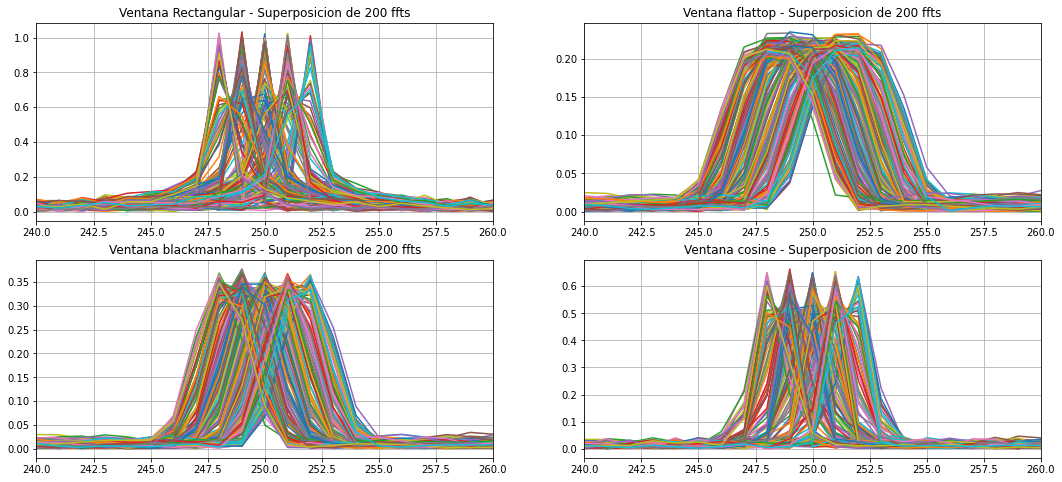

In [140]:
estimaciones_amp = np.zeros((len(arr_W), cant_realizaciones)) # Matriz de 4 filas 200 columnas
estimaciones_freq = np.zeros((len(arr_W), cant_realizaciones))

arr_ffts = np.zeros((len(arr_W), cant_realizaciones, N), dtype=complex)
for j in range(len(arr_W)):
    for i in range(cant_realizaciones):
        x_selec = x_3dB[i]  # señal i de doscientas
        w_selec = arr_W[j]  # Ventana 0 de cuatro, la rectangular (rectangular, flattop, blackmanharris, cosine)
        amplitud, frecuencia, fft_x = estimar_amp_frec(x_selec, w_selec)

        estimaciones_amp[j][i] = amplitud / N
        estimaciones_freq[j][i] = frecuencia
        arr_ffts[j,i, :] = fft_x / N
        
plt.figure(figsize=(18, 8))
for j in range(len(arr_W)):
    plt.subplot(2,2,j+1)
    plt.title(f"Ventana {arr_titulos_W[j]} - Superposicion de {cant_realizaciones} ffts")
    for i in np.arange(cant_realizaciones):
        plt.plot(np.real(arr_ffts[j][i]))
    plt.xlim(240,260)    
    plt.grid()
plt.show()

Calculo de sesgo y varianza de amplitud y frecuencia

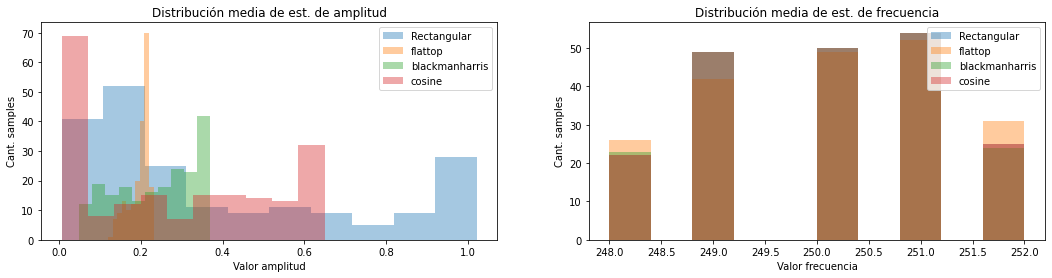

,Ventana,Sesgo,Varianza,Mean
0,Rectangular,0.377266,0.106226,0.379266
1,flattop,0.194998,0.000594,0.196998
2,blackmanharris,0.236014,0.009111,0.238014
3,cosine,0.281390,0.051808,0.283390


,Ventana,Sesgo,Varianza,Mean
0,Rectangular,249.805000,1.451975,250.055000
1,flattop,249.850000,1.600000,250.100000
2,blackmanharris,249.785000,1.453775,250.035000
3,cosine,249.805000,1.451975,250.055000


In [141]:
arr_colores = ['skyblue', 'orange', 'yellowgreen', 'lightcoral']
arr_amp = []; arr_ses_amp = []; arr_var_amp = []
arr_frec = []; arr_ses_frec = []; arr_var_frec = []
plt.figure(figsize=(18, 4))
for i in range(4):
    # Sesgo y varianza de amplitud
    mu_amp = np.mean(estimaciones_amp[i])
    sesgo_amp = mu_amp - (a0 / N)
    varianza_amp = np.mean((estimaciones_amp[i] - mu_amp)**2)
    arr_amp.append(mu_amp); arr_ses_amp.append(sesgo_amp); arr_var_amp.append(varianza_amp) # Guardo valores

    # Sesgo y varianza de frecuencia
    mu_freq = np.mean(estimaciones_freq[i])
    sesgo_freq = (mu_freq) - (omega0/(2*np.pi))
    varianza_freq = np.mean((estimaciones_freq[i] - mu_freq)**2)
    arr_frec.append(mu_freq); arr_ses_frec.append(sesgo_freq); arr_var_frec.append(varianza_freq) # Guardo valores
 
    plt.subplot(1,2,1)
    plt.hist(estimaciones_amp[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de amplitud"); plt.xlabel("Valor amplitud"); plt.ylabel("Cant. samples")
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(estimaciones_freq[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de frecuencia"); plt.xlabel("Valor frecuencia"); plt.ylabel("Cant. samples")
    plt.legend()
plt.show()

df_amp = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_ses_amp,
    'Varianza': arr_var_amp,
    'Mean': arr_amp,
})
df_amp = df_amp.style.set_caption("Estimación de Amplitud")
df_amp

df_frec = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_ses_frec,
    'Varianza': arr_var_frec,
    'Mean': arr_frec
})
df_frec = df_frec.style.set_caption("Estimación de Frecuencia")
df_frec

display(df_amp)
display(df_frec)

### Análisis de los resultados

Observamos que la estimación de amplitud es desastrosa, pero la varianza de esta esta correlacionada con la ventana aplicada. La ventana flat-top, que casi anula la variación de amplitud, presenta la menor varianza de las 4. Este efecto se ve reflejado en el "ancho de banda" de la distribucion media de estimaciones de amplitud, mientras mas anule la variacion en amplitud una ventana, menor variacion tendra su estimacion, lógicamente.
Mas alla de la varianza, el mal sesgo obtenido se debe a que el cálculo de la amplitud depende de que la frecuencia fundamental sea el valor que estamos asumiendo ($\omega_o = \pi/2$).
Es decir, este método es extremadamente susceptible a la variación de frecuencia, y se ve demostrado en la experimentación.

Por otro lado la estimación de frecuencia es excelente para cualquiera de las 4 ventanas, presentando también un grado similar de varianza. 

Es así como, sin modificar la lógica de como obtenemos frecuencia y amplitud, podríamos usar la estimación de frecuencias $\omega^i_1$ en reemplazo a la $\omega_o$ para mejorar la estimación de amplitud, pero esto depende que la señal que ingresa se trate de un tono puro, donde conociendo su frecuencia podemos asumir donde se encontrará su máximo.

## Zero-padding

Para realizar el padding puedo ambos padear la señal que ingresa o utilizar el parametro n de la funcion fft.
Yo voy a ir por el lado de el parametro n en la fft, por lo que redefino mi funcion de estimaciones tal que:

In [151]:
N_padding = N*10

def estimar_amp_frec(x,w):
    xw = x * w
    fft_xw = np.array(np.abs(fft(xw, n = N_padding))) # Parametro N es 10 veces mayor a las muestras en xw
    amplitud = estimar_amplitud(fft_xw)
    frecuencia = estimar_frecuencia(fft_xw)
    return amplitud, frecuencia, fft_xw

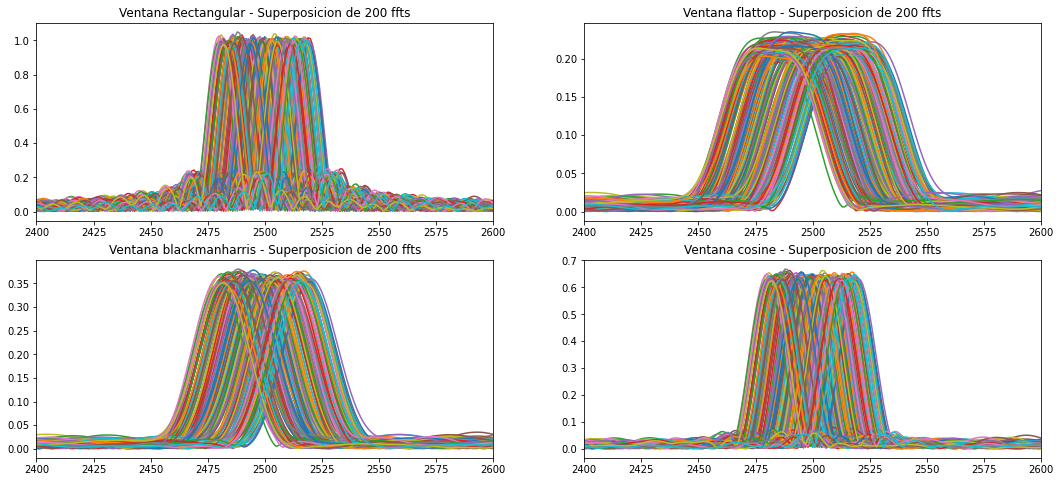

In [152]:
estimaciones_amp = np.zeros((len(arr_W), cant_realizaciones)) # Matriz de 4 filas 200 columnas
estimaciones_freq = np.zeros((len(arr_W), cant_realizaciones))

arr_ffts = np.zeros((len(arr_W), cant_realizaciones, N_padding), dtype=complex)
for j in range(len(arr_W)):
    for i in range(cant_realizaciones):
        x_selec = x_3dB[i]  # señal i de doscientas
        w_selec = arr_W[j]  # Ventana 0 de cuatro, la rectangular (rectangular, flattop, blackmanharris, cosine)
        amplitud, frecuencia, fft_x = estimar_amp_frec(x_selec, w_selec)

        estimaciones_amp[j][i] = amplitud / N
        estimaciones_freq[j][i] = frecuencia
        arr_ffts[j,i, :] = fft_x / N
        
plt.figure(figsize=(18, 8))
for j in range(len(arr_W)):
    plt.subplot(2,2,j+1)
    plt.title(f"Ventana {arr_titulos_W[j]} - Superposicion de {cant_realizaciones} ffts")
    for i in np.arange(cant_realizaciones):
        plt.plot(np.real(arr_ffts[j][i]))
    plt.xlim(2400,2600)    
plt.show()

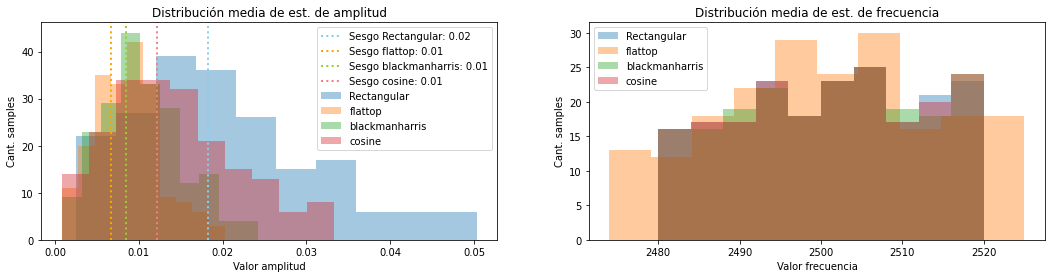

,Ventana,Sesgo,Varianza,Mean
0,Rectangular,0.018206,0.000120,0.020206
1,flattop,0.006692,0.000015,0.008692
2,blackmanharris,0.008468,0.000023,0.010468
3,cosine,0.012199,0.000058,0.014199


,Ventana,Sesgo,Varianza,Mean
0,Rectangular,2500.420000,127.931100,2500.670000
1,flattop,2500.440000,166.813900,2500.690000
2,blackmanharris,2500.420000,128.061100,2500.670000
3,cosine,2500.430000,128.157600,2500.680000


In [153]:
arr_colores = ['skyblue', 'orange', 'yellowgreen', 'lightcoral']
arr_amp = []; arr_ses_amp = []; arr_var_amp = []
arr_frec = []; arr_ses_frec = []; arr_var_frec = []
plt.figure(figsize=(18, 4))
for i in range(4):
    # Sesgo y varianza de amplitud
    mu_amp = np.mean(estimaciones_amp[i])
    sesgo_amp = mu_amp - (a0 / N)
    varianza_amp = np.mean((estimaciones_amp[i] - mu_amp)**2)
    arr_amp.append(mu_amp); arr_ses_amp.append(sesgo_amp); arr_var_amp.append(varianza_amp) # Guardo valores

    # Sesgo y varianza de frecuencia
    mu_freq = np.mean(estimaciones_freq[i])
    sesgo_freq = (mu_freq) - (omega0/(2*np.pi))
    varianza_freq = np.mean((estimaciones_freq[i] - mu_freq)**2)
    arr_frec.append(mu_freq); arr_ses_frec.append(sesgo_freq); arr_var_frec.append(varianza_freq) # Guardo valores
 
    plt.subplot(1,2,1)
    plt.hist(estimaciones_amp[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de amplitud"); plt.xlabel("Valor amplitud"); plt.ylabel("Cant. samples")
    plt.axvline(sesgo_amp, color=arr_colores[i], linestyle=':', linewidth=2, label=f'Sesgo {arr_titulos_W[i]}: {sesgo_amp:.2f}')
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(estimaciones_freq[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de frecuencia"); plt.xlabel("Valor frecuencia"); plt.ylabel("Cant. samples")
    plt.legend()
plt.show()

df_amp = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_ses_amp,
    'Varianza': arr_var_amp,
    'Mean': arr_amp,
})
df_amp = df_amp.style.set_caption("Estimación de Amplitud")
df_amp

df_frec = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_ses_frec,
    'Varianza': arr_var_frec,
    'Mean': arr_frec
})
df_frec = df_frec.style.set_caption("Estimación de Frecuencia")
df_frec

display(df_amp)
display(df_frec)

### Análisis de resultados

El efecto padding se aprecia tanto en las distribuciones de frecuencia como los valores de amplitud sesgados. 

En la distribución de frecuencias ya no se aprecian los bins claramente delimitados entre salto y salto de valor, si no que cada ventana presenta un área de posibles valores. Acá es donde se puede apreciar como el efecto de "allanamiento" de flat-top resulta contraproducente en el análisis de frecuencia fundamental, teniendo una varianza notablemente mayor al del resto de las ventanas. Esto tiene total sentido, dado que la lógica de estimación depende de encontrar el máximo valor en la fft.

Para la estimación de amplitud, este aumento en definición que otorga el paddding mejora considerablemente los resultados obtenidos.

## Estimadores alternativos

Para la amplitud se propone una interpolacion parabolica. Este metodo estima el valor maximo de la fft en 3 valores, estimando con mayor precicion donde esta el pico real.

El indice delta va a estimar cuanto se desplazo el pico real del valor estimado como pico ($X_0$). Si delta = 0, el pico esta en $X_0$:
$$\delta = \frac{1}{2} \cdot \frac{X_{-1} - X_{+1}}{X_{-1} - 2X_0 + X_{+1}}$$

Con este delta puedo corregir el indice utilizado para la frecuencia fundamental y la magnitud estimada:
$$k_{\text{interp}} = k + \delta$$
$$|X|_{\text{interp}} = X_0 - \frac{1}{4}(X_{-1} - X_{+1}) \cdot \delta$$

In [154]:
def interpolacion_parabolica(Xw):

    Xw_pos = Xw[:N//2] # Solo analizo el espetro positivo
    mags = np.abs(Xw_pos) # Calculo modulo de la FFT
    k = np.argmax(mags)   
    
    #k = np.argmax(mags[1:-1]) + 1 # Bin de máxima magnitud (sin contar DC ni Nyquist)

    xa = mags[k - 1]     # X-1
    xb = mags[k]          # X0
    xc = mags[k + 1]     # X+1

    #Obtengo el delta
    den_delta = xa - 2 * xb + xc
    if den_delta == 0:
        delta = 0
    else:
        delta = 0.5 * (xa - xc) / den_delta

    amp_interpolada = xb - 0.25 * (xa - xc) * delta
    amp_est = 2 * amp_interpolada / N # Escalo la amplitud calculada a la fft

    frec_interpolada = k + delta
    frec_est = (frec_interpolada / N) * fs

    return amp_est, frec_est

def estimar_amp_frec(x,w):
    xw = x * w
    fft_xw = np.array(np.abs(fft(xw)))
    amplitud, frecuencia = interpolacion_parabolica(fft_xw)
    return amplitud, frecuencia, fft_xw

In [158]:
estimaciones_amp = np.zeros((len(arr_W), cant_realizaciones)) # Matriz de 4 filas 200 columnas
estimaciones_freq = np.zeros((len(arr_W), cant_realizaciones))

arr_ffts = np.zeros((len(arr_W), cant_realizaciones, N), dtype=complex)
for j in range(len(arr_W)):
    for i in range(cant_realizaciones):
        x_selec = x_3dB[i]  # señal i de doscientas
        w_selec = arr_W[j]  # Ventana 0 de cuatro, la rectangular (rectangular, flattop, blackmanharris, cosine)
        amplitud, frecuencia, fft_x = estimar_amp_frec(x_selec, w_selec)

        estimaciones_amp[j][i] = amplitud / N
        estimaciones_freq[j][i] = frecuencia
        arr_ffts[j,i, :] = fft_x / N
        
''' No me interesa
plt.figure(figsize=(18, 8))
for j in range(len(arr_W)):
    plt.subplot(2,2,j+1)
    plt.title(f"Ventana {arr_titulos_W[j]} - Superposicion de {cant_realizaciones} ffts")
    for i in np.arange(cant_realizaciones):
        plt.plot(np.real(arr_ffts[j][i]))
    plt.xlim(240,260)    
    plt.grid()
plt.show()'''

' No me interesa\nplt.figure(figsize=(18, 8))\nfor j in range(len(arr_W)):\n    plt.subplot(2,2,j+1)\n    plt.title(f"Ventana {arr_titulos_W[j]} - Superposicion de {cant_realizaciones} ffts")\n    for i in np.arange(cant_realizaciones):\n        plt.plot(np.real(arr_ffts[j][i]))\n    plt.xlim(240,260)    \n    plt.grid()\nplt.show()'

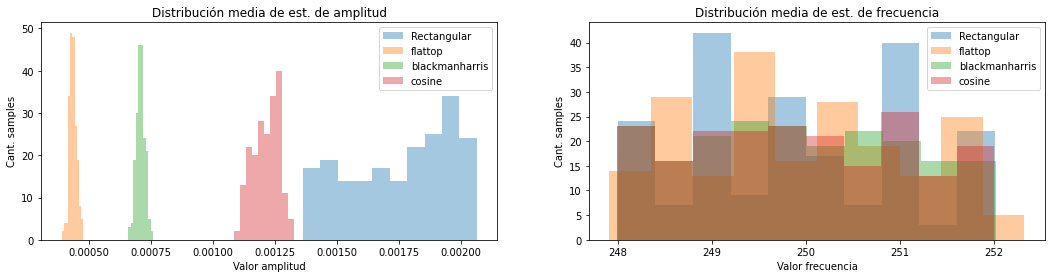

,Ventana,Sesgo,Varianza,Mean,Mean normalizado por rectangular,Mean norm esperado
0,Rectangular,-0.000243,0.000000,0.001757,1.000000,1
1,flattop,-0.001565,0.000000,0.000435,0.247484,"~0,22"
2,blackmanharris,-0.001291,0.000000,0.000709,0.403334,~0.37
3,cosine,-0.000785,0.000000,0.001215,0.691670,~0.65


,Ventana,Sesgo,Varianza,Mean
0,Rectangular,249.682306,1.391590,249.932306
1,flattop,249.691894,1.296836,249.941894
2,blackmanharris,249.684176,1.300348,249.934176
3,cosine,249.682982,1.312810,249.932982


In [163]:
arr_colores = ['skyblue', 'orange', 'yellowgreen', 'lightcoral']
arr_amp = []; arr_ses_amp = []; arr_var_amp = []
arr_frec = []; arr_ses_frec = []; arr_var_frec = []
plt.figure(figsize=(18, 4))
for i in range(4):
    # Sesgo y varianza de amplitud
    mu_amp = np.mean(estimaciones_amp[i])
    sesgo_amp = mu_amp - (a0 / N)
    varianza_amp = np.mean((estimaciones_amp[i] - mu_amp)**2)
    arr_amp.append(mu_amp); arr_ses_amp.append(sesgo_amp); arr_var_amp.append(varianza_amp) # Guardo valores

    # Sesgo y varianza de frecuencia
    mu_freq = np.mean(estimaciones_freq[i])
    sesgo_freq = (mu_freq) - (omega0/(2*np.pi))
    varianza_freq = np.mean((estimaciones_freq[i] - mu_freq)**2)
    arr_frec.append(mu_freq); arr_ses_frec.append(sesgo_freq); arr_var_frec.append(varianza_freq) # Guardo valores
 
    plt.subplot(1,2,1)
    plt.hist(estimaciones_amp[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de amplitud"); plt.xlabel("Valor amplitud"); plt.ylabel("Cant. samples")
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(estimaciones_freq[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de frecuencia"); plt.xlabel("Valor frecuencia"); plt.ylabel("Cant. samples")
    plt.legend()
plt.show()
arr_amp_normalizado = arr_amp/arr_amp[0]
df_amp = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_ses_amp,
    'Varianza': arr_var_amp,
    'Mean': arr_amp,
    'Mean normalizado por rectangular': arr_amp_normalizado,
    'Mean norm esperado': ['1', '~0,22', '~0.37', '~0.65']
})
df_amp = df_amp.style.set_caption("Estimación de Amplitud")
df_amp

df_frec = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_ses_frec,
    'Varianza': arr_var_frec,
    'Mean': arr_frec
})
df_frec = df_frec.style.set_caption("Estimación de Frecuencia")
df_frec

display(df_amp)
display(df_frec)

### Análisis de resultados

En el caso de amplitud, vemos que obtenemos un sesgo infimamente menor al de ambos casos, con y cero padding, indicando la mejora del estimador.

La estimacion de frecuencia tambien tiene una ligera ventaja frente al metodo de estimacion anterior, con una menor varianza, aunque no sea una ventaja tan marcada como en la estimacion de amplitud.